# SET UP

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv
import scipy
import string
from scipy.stats import spearmanr, pearsonr
import numpy as np
import glob
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8' )

'en_US.UTF-8'

In [3]:
ADcsv_directory = os.path.join(os.getcwd(), 'analyzed_dfs/AD')
ADexperiments_dict = {}

# Iterate over files in the directory
for filename in os.listdir(ADcsv_directory):
#     print(filename)
    # Check if the file is a regular file
    if os.path.isfile(os.path.join(ADcsv_directory, filename)):
        # Assuming all files are CSV, adjust the condition as needed
        if filename.endswith('.csv'):
            # Read the file into a DataFrame
            df = pd.read_csv(os.path.join(ADcsv_directory, filename), index_col=0)
            # Get the value in column x of row 1
            key_value = '_'.join(df.iloc[0]['Library'].split('_')[:3])
            df['Library'] = key_value
            # Store the DataFrame in the dictionary with the key as the value in column x of row 1
            ADexperiments_dict[key_value] = df
#             print(key_value)

            
RPTRcsv_directory = os.path.join(os.getcwd(), 'analyzed_dfs/RPTR')
RPTRexperiments_dict = {}
            
for filename in os.listdir(RPTRcsv_directory):
#     print(filename)
    # Check if the file is a regular file
    if os.path.isfile(os.path.join(RPTRcsv_directory, filename)):
        # Assuming all files are CSV, adjust the condition as needed
        if filename.endswith('.csv'):
            # Read the file into a DataFrame
            df = pd.read_csv(os.path.join(RPTRcsv_directory, filename), index_col=0)
            # Get the value in column x of row 1
            key_value = '_'.join(df.iloc[0]['Library'].split('_')[:3])
            df['Library'] = key_value
            # Store the DataFrame in the dictionary with the key as the value in column x of row 1
            RPTRexperiments_dict[key_value] = df
#             print(key_value)
            
# Now 'dfs' contains a dictionary where keys are the values in column x of row 1, and values are the corresponding DataFrames

In [4]:
# get paired read counts
pear_f = '/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Sep2024/ciber2_iii_MZ001/EC_Ciber2_iii_Gcn4/slurm-21591255.out'
paired = {}
lib = None
count = None

with open (pear_f, 'r') as f:
    for line in f:
        if line.startswith('Assembled reads ...................:'):
            count = line.split(':')[1].split('/')[0]
            count = locale.atoi(count)
            # print(count)
        elif line.startswith('Assembled reads file...............:'):
            lib = line.split(':')[1].split('/')[1].split('_')[:3]
            lib = '_'.join(lib)
            # print(lib)
        # Only add to the dictionary when both lib and count are defined
        if lib and count:
            paired[lib] = count
            lib = None  # Reset lib and count after storing in the dictionary
            count = None
paired['RPTR_3_180']

29111285

In [5]:
# assign total paired to each lib
howmanylibs = 0
print(ADexperiments_dict['AD_2_0'].shape)
for library in ADexperiments_dict.keys(): 
    # print()
    ADexperiments_dict[library]['Allreads'] = paired[library]
    howmanylibs+=1
print(howmanylibs == len(ADexperiments_dict))
print(ADexperiments_dict['AD_2_0'].shape)

(19215, 4)
True
(19215, 5)


In [6]:
# assign total paired to each lib
howmanylibs = 0
print(RPTRexperiments_dict['RPTR_2_0'].shape)
for library in RPTRexperiments_dict.keys():
    # print()
    RPTRexperiments_dict[library]['Allreads'] = paired[library]
    howmanylibs+=1
print(howmanylibs == len(RPTRexperiments_dict))
print(RPTRexperiments_dict['RPTR_2_0'].shape)

(15605, 4)
True
(15605, 5)


# Merge Data

In [7]:
merged_dfs = {}

for key in ADexperiments_dict.keys():
    print(key)
    # Extracting the corresponding AD and RPTR dataframes
    ad_df = ADexperiments_dict[key]
    ad_df_size = ad_df.shape[0]
    # print(f'{key} has {ad_df_size} AD entries')
    rptr_df = RPTRexperiments_dict[key.replace("AD", "RPTR")]
    rptr_df_size = rptr_df.shape[0]
    # print(f'{key} has {rptr_df_size} RPTR entries')

    # Merging the dataframes
    merged_df = pd.merge(rptr_df, ad_df, 
                         left_on='BCs', right_on='PutativeRPTR', 
                         how='inner', suffixes=('_r', '_a'))
    # merged_df[['BCs', 'Tile-AD']]+=1 # september 4, 2024
    merged_df_size = merged_df.shape[0]
    print(f'{key} has {merged_df_size} merged entries')
    print('%RPTRloss:', (1-merged_df_size/rptr_df_size) * 100)
    print('%ADloss:', (1-merged_df_size/ad_df_size) *100)
    merged_df = merged_df.drop(['Library_r','PutativeRPTR'], axis=1)
    merged_df['R_normalized'] = merged_df['count_r'] / merged_df['Allreads_r'] #create a column that normalizes for read depth
    merged_df['A_normalized'] = merged_df['count_a'] / merged_df['Allreads_a'] #create a column that normalizes for read depth
    merged_df['Ratio'] = merged_df['R_normalized'] / merged_df['A_normalized']    
    merged_df[['Tile', 'AD']] = merged_df['Tile-AD'].str.split('-', expand=True) 
    merged_df = merged_df.drop(['PutativeTileADBC', 'Allreads_r'], axis=1) 
    #sequencing errors, drop anything less than 10 reads
    merged_df = merged_df[merged_df['count_a']>=10]
    print('RPTR BC after filtering:', merged_df.shape[0], '%loss:', ((1-merged_df.shape[0]/merged_df_size)*100))
    # # for tiles represented by 2 RPTR BCs, take average of activity
    # merged_df = merged_df.groupby('Tile')['Ratio'].mean(numeric_only=False).reset_index() #get means of ratios
    # merged_df = merged_df.rename(columns={'Ratio':'av_Ratio'})


#     Storing the merged dataframe in a dictionary
    merged_dfs[key] = merged_df


AD_3_30
AD_3_30 has 15194 merged entries
%RPTRloss: 1.847545219638247
%ADloss: 21.033210332103323
RPTR BC after filtering: 14945 %loss: 1.6388047913650117
AD_2_240
AD_2_240 has 15272 merged entries
%RPTRloss: 2.1339314322332603
%ADloss: 20.524562864279773
RPTR BC after filtering: 15006 %loss: 1.7417496071241434
AD_4_5
AD_4_5 has 15277 merged entries
%RPTRloss: 2.0139824257584538
%ADloss: 20.341015747210346
RPTR BC after filtering: 15030 %loss: 1.6168095830333185
AD_3_240
AD_3_240 has 15280 merged entries
%RPTRloss: 2.1014864172219427
%ADloss: 20.26300683609038
RPTR BC after filtering: 14994 %loss: 1.8717277486910988
AD_4_240
AD_4_240 has 15243 merged entries
%RPTRloss: 2.0750353334189953
%ADloss: 20.67547876769359
RPTR BC after filtering: 14988 %loss: 1.67289903562291
AD_2_10
AD_2_10 has 15238 merged entries
%RPTRloss: 2.0694087403599015
%ADloss: 20.478029433253308
RPTR BC after filtering: 14958 %loss: 1.8375114844467744
AD_3_15
AD_3_15 has 15247 merged entries
%RPTRloss: 2.03675147776

In [9]:
# tmp = merged_dfs['AD_4_30']['BCs'].value_counts().to_frame().reset_index() #.BCs.to_list()
# tmp = tmp[tmp['count']>1].BCs.to_list()
# merged_dfs['AD_4_30'].set_index('BCs').loc[tmp,]

In [10]:
t5 = []
t10 = []
t15 = []
t30 = []
t180 = []
t240 = []

for key in merged_dfs.keys():
    if key.endswith('_5'):
        print(key)
        merged_dfs[key]['Library'] = key
        t5.append(merged_dfs[key])
    if key.endswith('_10'):
        print(key)
        merged_dfs[key]['Library'] = key
        t10.append(merged_dfs[key])
    if key.endswith('_15'):
        print(key)
        merged_dfs[key]['Library'] = key
        t15.append(merged_dfs[key])  
    if key.endswith('_30'):
        print(key)
        merged_dfs[key]['Library'] = key
        t30.append(merged_dfs[key])
    if key.endswith('_180'):
        print(key)
        merged_dfs[key]['Library'] = key
        t180.append(merged_dfs[key])
    if key.endswith('_240'):
        print(key)
        merged_dfs[key]['Library'] = key
        t240.append(merged_dfs[key])      
        
        
t5_all = pd.concat(t5, ignore_index=True)
t5_all['R_norm_rpm'] = t5_all['R_normalized']*10e6
t5_all['A_norm_rpm'] = t5_all['A_normalized']*10e6
t10_all = pd.concat(t10, ignore_index=True)
t10_all['R_norm_rpm'] = t10_all['R_normalized']*10e6
t10_all['A_norm_rpm'] = t10_all['A_normalized']*10e6
t15_all = pd.concat(t15, ignore_index=True)
t15_all['R_norm_rpm'] = t15_all['R_normalized']*10e6
t15_all['A_norm_rpm'] = t15_all['A_normalized']*10e6
t30_all = pd.concat(t30, ignore_index=True)
t30_all['R_norm_rpm'] = t30_all['R_normalized']*10e6
t30_all['A_norm_rpm'] = t30_all['A_normalized']*10e6
t180_all = pd.concat(t180, ignore_index=True)
t180_all['R_norm_rpm'] = t180_all['R_normalized']*10e6
t180_all['A_norm_rpm'] = t180_all['A_normalized']*10e6
t240_all = pd.concat(t240, ignore_index=True)
t240_all['R_norm_rpm'] = t240_all['R_normalized']*10e6
t240_all['A_norm_rpm'] = t240_all['A_normalized']*10e6

# print(t10_all.head())
print(t10_all.tail())

AD_3_30
AD_2_240
AD_4_5
AD_3_240
AD_4_240
AD_2_10
AD_3_15
AD_3_5
AD_2_15
AD_3_10
AD_4_30
AD_2_5
AD_3_180
AD_4_15
AD_2_30
AD_4_10
AD_4_180
AD_2_180
                  BCs  count_r  \
44870  TTTAGACAACGAGT        1   
44871  CGCCACTCACCACT        1   
44872  ATCAATATTCTACT        1   
44873  CCTAGGCCTATCGC        1   
44874  TAGATCTATTTTTG        1   

                                                 Tile-AD  count_a Library_a  \
44870  GACTTTGTCTTGTATCCATCTCAACATCCAAGAGATTCTAGAGCTC...      460   AD_4_10   
44871  GTTACTACTACTTCTTCTTCTTCTAGAAGGAAATCTGGTGGTTCTC...       10   AD_4_10   
44872  AGAAGATCTTCTTCTAGAGTTTCTGCTACTATCTTGCCAAGAGACT...       16   AD_4_10   
44873  ACTACTAGAAGAAGATCTGGTACTGGTGGTTCTTCTCCAACTTCTG...       40   AD_4_10   
44874  CAATGTTTGTTAAATTCTGGTGGTTCTGCTAGACCATTGATTATTT...       48   AD_4_10   

       Allreads_a  R_normalized  A_normalized     Ratio  \
44870    29420842  4.201155e-08  1.563517e-05  0.002687   
44871    29420842  4.201155e-08  3.398951e-07  0.123602

# Analyze merged Ciber data

In [11]:
# Function to annotate with Spearman correlation, dropping NaNs
def corrfunc(x, y, **kws):
    # Drop NaN values from both x and y
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    if np.sum(mask) == 0:
        r = 0  # If there are no valid data points left after dropping NaNs, set r to 0
    else:
        # Compute Spearman correlation with valid (non-NaN) data
        r, _ = spearmanr(x[mask], y[mask])

    # Plot annotation
    ax = plt.gca()
    ax.annotate(f'Spearman r = {r:.2f}', xy=(0.5, 0.1), xycoords=ax.transAxes, ha='center', fontsize=12)


def pivoter(alldf, piv_values, saveas=False):
    """
    takes concatenated df containing columns: index_x	BCs	PutativeTileADBC	Tile-AD	Library_y	Allreads_y	R_normalized	A_normalized	Ratio	Tile	AD	Library
    returns df where each row is a barcode and its corresponding tile and activity score for each replicate in columns
    prints a scatterplot matrix of activity scores against one another
    saves resulting df as a csv
    
    alldf : pandas_df -- concatenated df to pivot (eg t*_all)
    piv_values : {{“R_normalized”, “A_normalized”, “Ratio”}}  -- column with values to pivot on
    saveas : bool -- True to save resulting df as a csv. Will overwrite.
    """

    collapsed = alldf.pivot_table(index='BCs', columns='Library', values=piv_values).reset_index()
    collapsed = pd.merge(collapsed, alldf[['BCs', 'Tile']].drop_duplicates(), on='BCs')
    print('Barcodes represented total:', collapsed.shape[0])
    print('Barcodes represented in at least one but not all replicates:',collapsed[collapsed.isna().any(axis=1)].shape[0])
    num_cols = collapsed.select_dtypes(include='float').columns.tolist()

    # p = sns.pairplot(collapsed.fillna(1e-5), plot_kws={"marker": "x", "alpha": 0.5})
    p = sns.pairplot(collapsed.dropna(), plot_kws={"marker": "x", "alpha": 0.5})
    p.set(xscale="log", yscale="log")
    p.map_lower(corrfunc)
    name_time = num_cols[0].split('_')[2]
    name_type = piv_values.split('_')[0].lower()
    if piv_values == 'Ratio':
        plt.suptitle(f't = {name_time}min, Ratio ', y=1.02)
    else :
        plt.suptitle(f't = {name_time}min, {name_type}-bc (reads per million)', y=1.02)

    if saveas :
        plt.savefig(f'merged_dfs/t{name_time}_{name_type}.jpg')
        print(f"Saved to: merged_dfs/t{name_time}{name_type}_norm_nans.csv'")
        collapsed.to_csv(f'merged_dfs/t{name_time}{name_type}_norm_nans.csv')
    else:
        plt.show()

    return collapsed


AD ABUNDANCE
Barcodes represented total: 15242
Barcodes represented in at least one but not all replicates: 667
Saved to: merged_dfs/t30a_norm_nans.csv'
RPTR ABUNDANCE
Barcodes represented total: 15242
Barcodes represented in at least one but not all replicates: 667
Saved to: merged_dfs/t30r_norm_nans.csv'
RATIO
Barcodes represented total: 15242
Barcodes represented in at least one but not all replicates: 667
Saved to: merged_dfs/t30ratio_norm_nans.csv'
AD ABUNDANCE
Barcodes represented total: 15249
Barcodes represented in at least one but not all replicates: 643
Saved to: merged_dfs/t180a_norm_nans.csv'
RPTR ABUNDANCE
Barcodes represented total: 15249
Barcodes represented in at least one but not all replicates: 643
Saved to: merged_dfs/t180r_norm_nans.csv'
RATIO
Barcodes represented total: 15249
Barcodes represented in at least one but not all replicates: 643
Saved to: merged_dfs/t180ratio_norm_nans.csv'
AD ABUNDANCE
Barcodes represented total: 15273
Barcodes represented in at least o

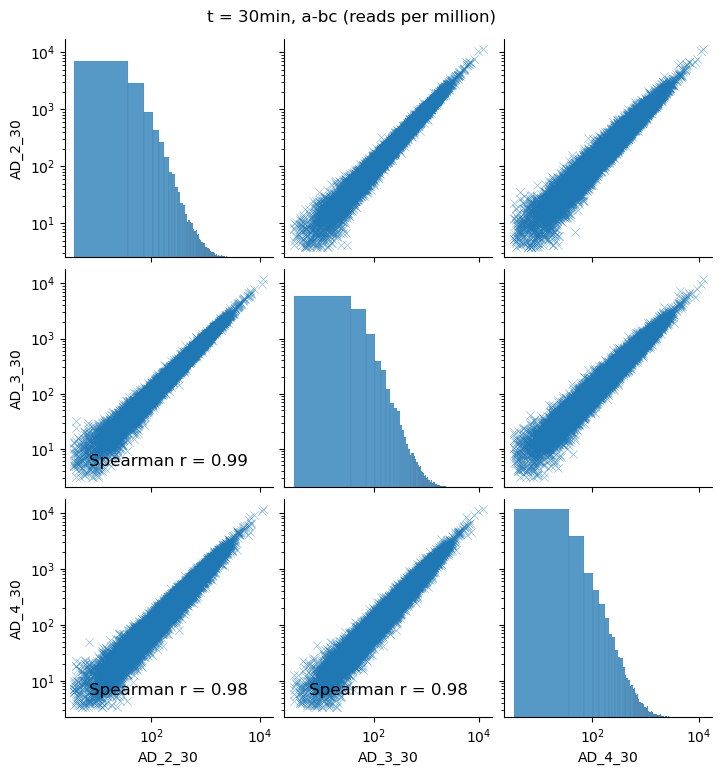

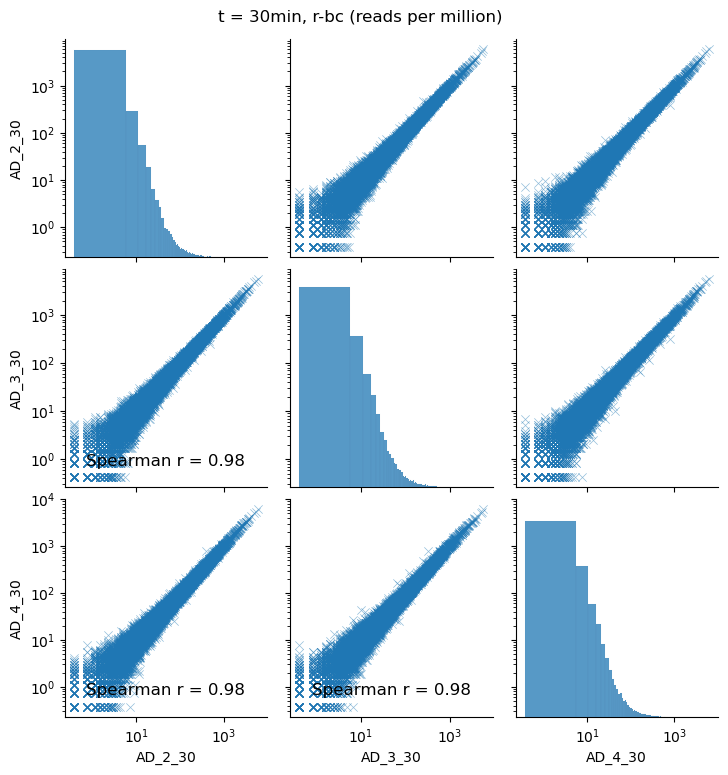

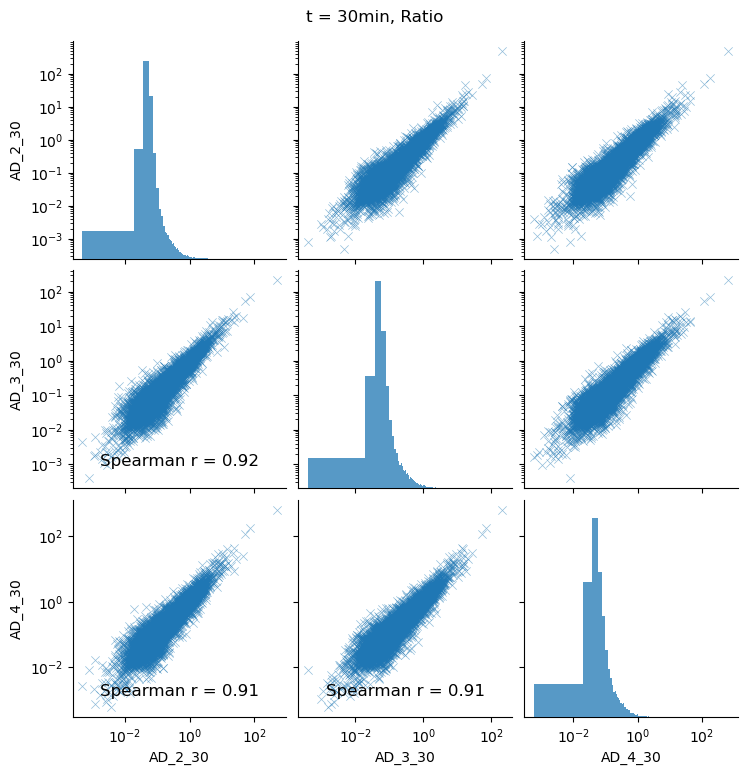

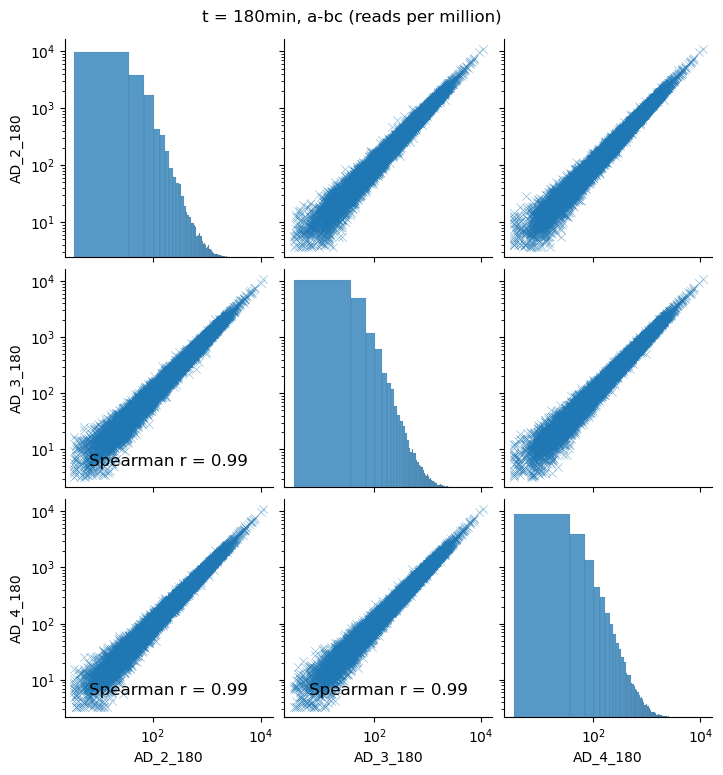

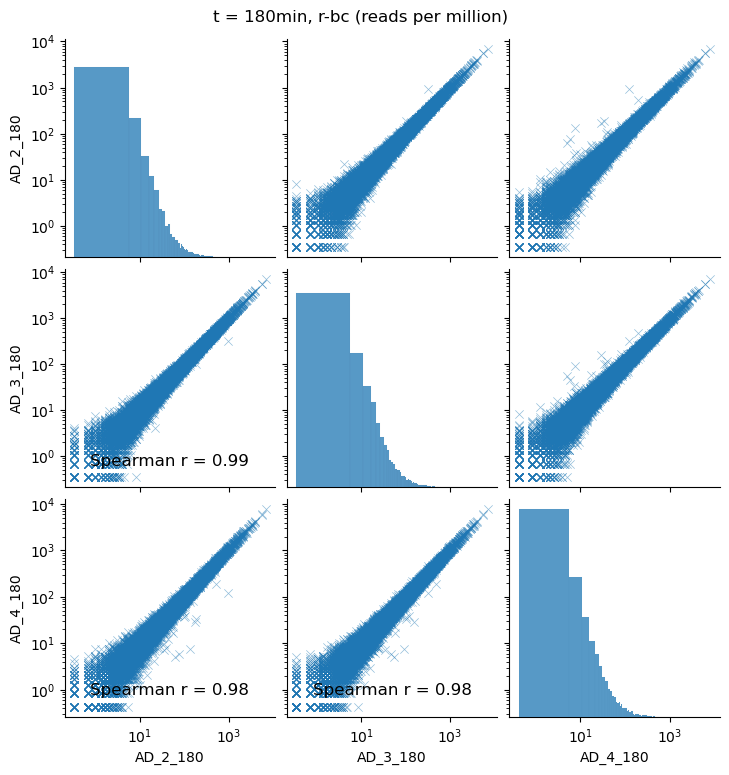

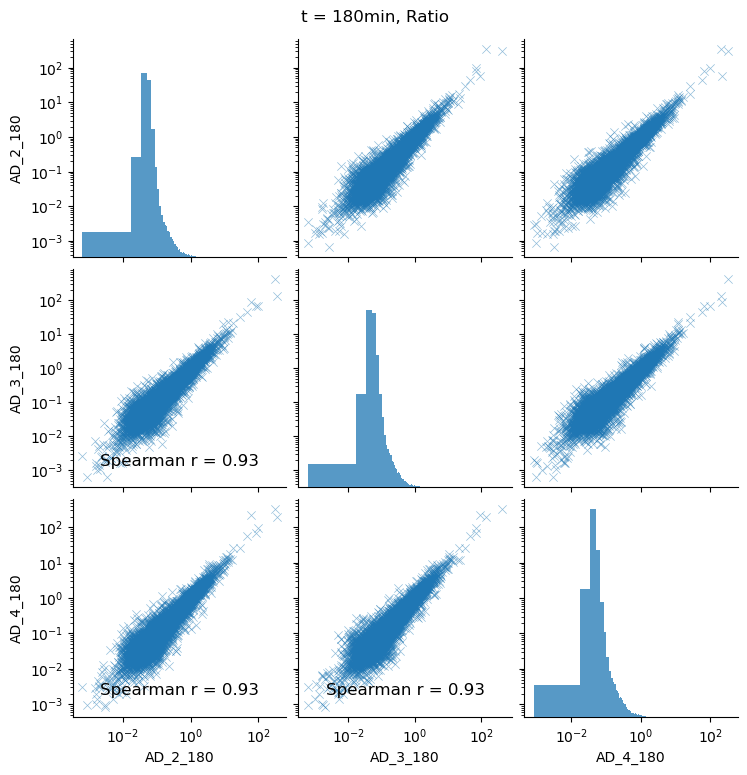

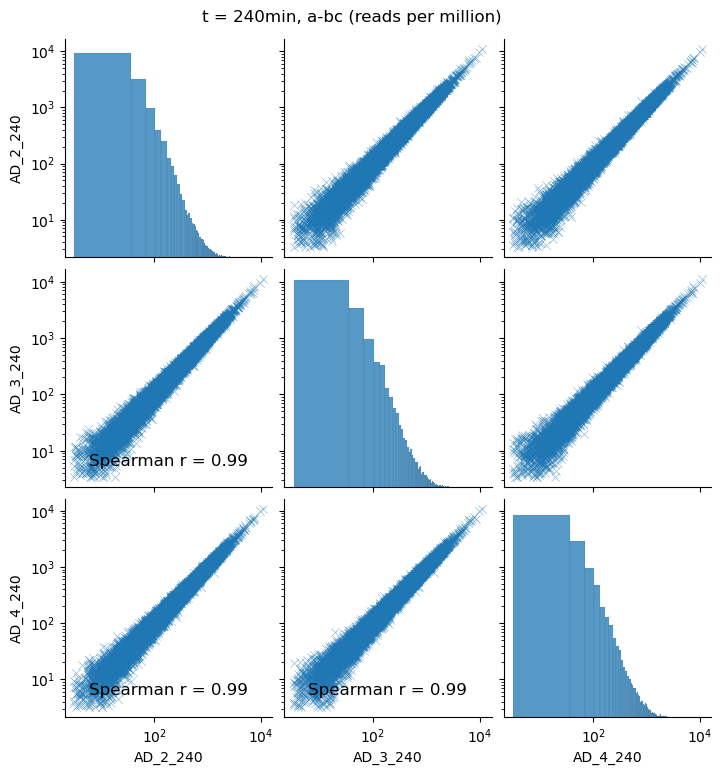

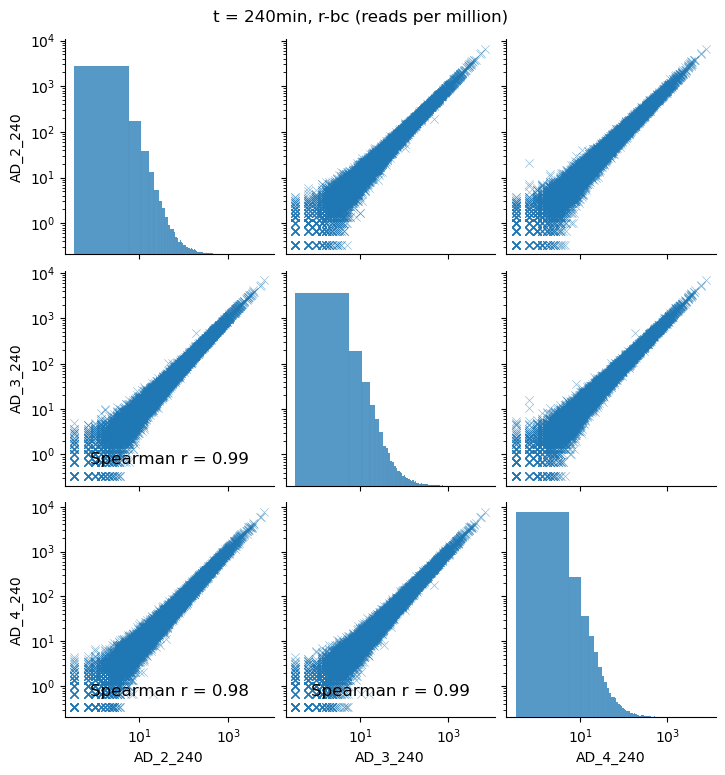

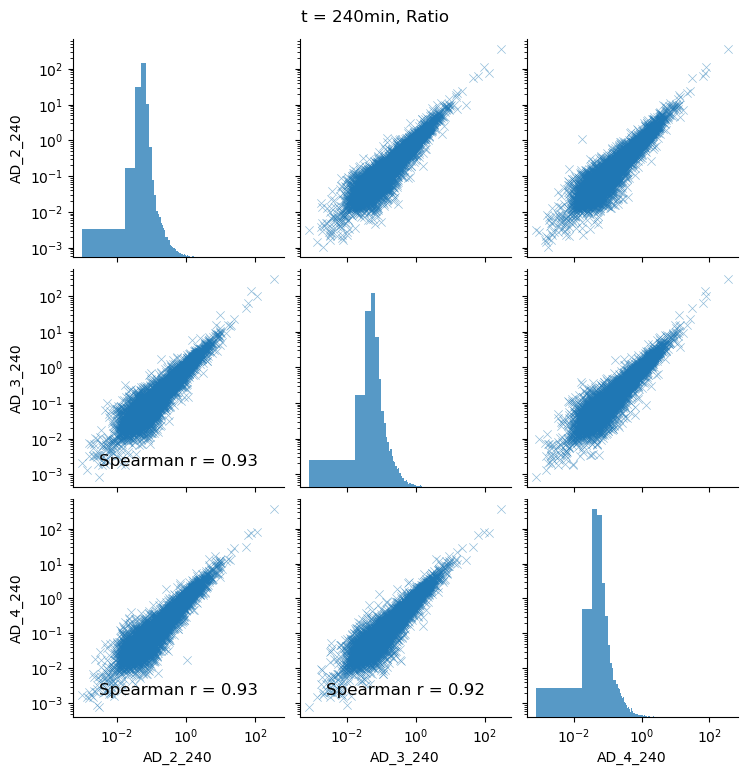

In [12]:
# dfs_toprocess = [
#     # t5_all, t10_all, t15_all, 
#     t30_all, t180_all, t240_all]

# for d in dfs_toprocess:
#     print('AD ABUNDANCE')
#     pivoter(d, 'A_norm_rpm', True)
#     print('RPTR ABUNDANCE')
#     pivoter(d, 'R_norm_rpm', True)
#     print('RATIO')
#     pivoter(d, 'Ratio', True )

/global/home/users/empchase/.conda/envs/biopython/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/global/home/users/empchase/.conda/envs/biopython/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/global/home/users/empchase/.conda/envs/biopython/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/global/home/users/empchase/.conda/envs/biopython/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use strip

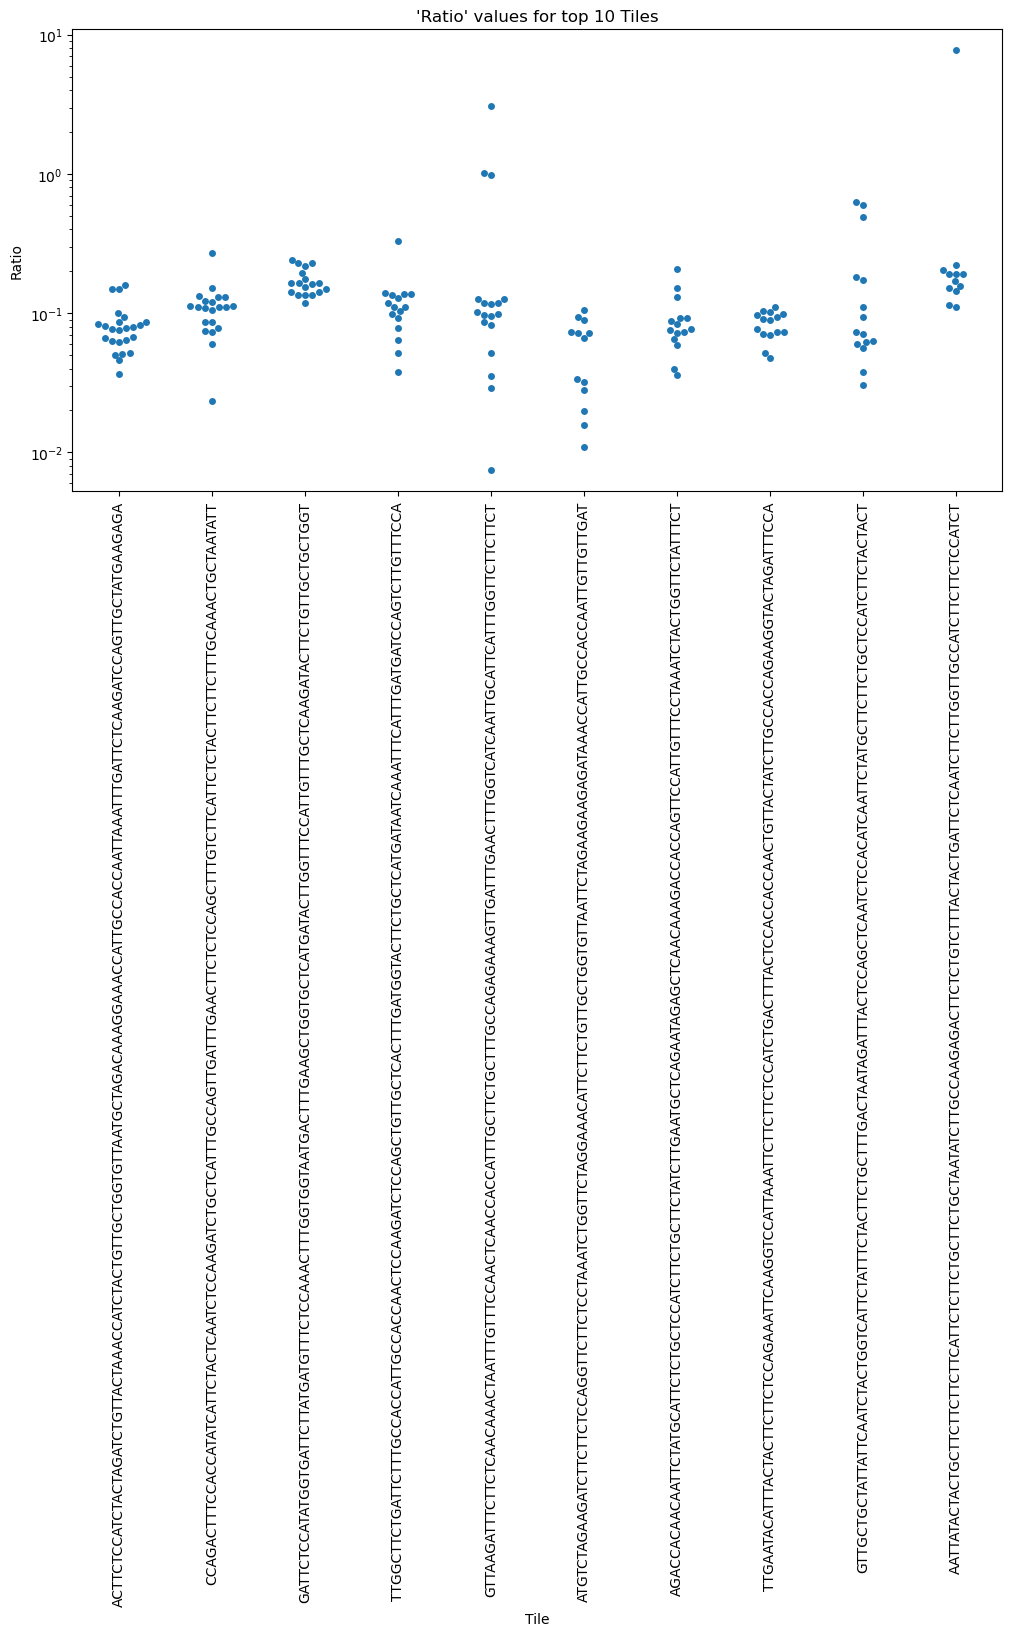

In [14]:
# Step 1: Find the top 10 tiles with the most unique rptr barcodes
top_tiles = t10_all.groupby('Tile')['BCs'].nunique().reset_index()
top_tiles_sorted = top_tiles.sort_values('BCs', ascending=False)
top_10_tiles = top_tiles_sorted.head(10)['Tile']

# Step 2: Filter the original dataframe to include only the top 10 tiles
df_filtered = t10_all[t10_all['Tile'].isin(top_10_tiles)]

# Step 3: Generate the violin plot
plt.figure(figsize=(12, 6))
sns.swarmplot(x='Tile', y='Ratio', data=df_filtered, order=top_10_tiles, )
# Set the y-axis to a log scale
plt.yscale('log')
# Customize plot
plt.xticks(rotation=90)
plt.title("'Ratio' values for top 10 Tiles")
plt.xlabel("Tile")
plt.ylabel("Ratio")

# Show the plot
plt.tight_layout()
plt.show()


# Read in FACS data

In [17]:
keepcolsgfp = ['DNAseq', 
            'numreads_per_AD_1AGFP', 'Activity_1AGFP', 'numreads_per_AD_4BGFP', 'Activity_4BGFP',
        
           ]

keepcolscherry = ['DNAseq', 
            'numreads_per_AD_2AmCh', 'Activity_2AmCh', 'numreads_per_AD_5BmCh', 'Activity_5BmCh',
           ]

keepcolsratio = ['DNAseq', 
            'numreads_per_AD_3ARatio_redoseq', 'Activity_3ARatio_redoseq', 'numreads_per_AD_6BRatio', 'Activity_6BRatio'
           ]

FACSgfp = pd.read_csv('BYS4combined.csv', usecols=keepcolsgfp)
print(FACSgfp.dropna().shape)

FACScherry = pd.read_csv('BYS4combined.csv', usecols=keepcolscherry)
print(FACScherry.dropna().shape)

FACSratio = pd.read_csv('BYS4combined.csv', usecols=keepcolsratio)
print(FACSratio.dropna().shape)

print(FACSratio.shape)

(7904, 5)
(9077, 5)
(10128, 5)
(18944, 5)


In [18]:
# at least 1000 reads
readsfiltered_FACSgfp = FACSgfp[(FACSgfp['numreads_per_AD_1AGFP']>=1000) & (FACSgfp['numreads_per_AD_4BGFP']>=1000)]
print(readsfiltered_FACSgfp.shape)
readsfiltered_FACScherry = FACScherry[(FACScherry['numreads_per_AD_2AmCh']>=1000) & (FACScherry['numreads_per_AD_5BmCh']>=1000)]
print(readsfiltered_FACScherry.shape)
readsfiltered_FACSratio = FACSratio[(FACSratio['numreads_per_AD_3ARatio_redoseq']>=1000) & (FACSratio['numreads_per_AD_6BRatio']>=1000)]
print(readsfiltered_FACSratio.shape)

# only 10% difference between the samples
# deciding now to use mean as the reference
filtered_FACSgfp = readsfiltered_FACSgfp.copy(deep=True)
filtered_FACSgfp['pct_diff'] = abs(filtered_FACSgfp['Activity_1AGFP'] - filtered_FACSgfp['Activity_4BGFP'])/((filtered_FACSgfp['Activity_1AGFP'] + filtered_FACSgfp['Activity_4BGFP'])/2)
filtered_FACSgfp = filtered_FACSgfp[filtered_FACSgfp['pct_diff']<=0.10]
print(filtered_FACSgfp.shape)

filtered_FACScherry = readsfiltered_FACScherry.copy(deep=True)
filtered_FACScherry['pct_diff'] = abs(filtered_FACScherry['Activity_2AmCh'] - filtered_FACScherry['Activity_5BmCh'])/((filtered_FACScherry['Activity_2AmCh'] + filtered_FACScherry['Activity_5BmCh'])/2)
filtered_FACScherry = filtered_FACScherry[filtered_FACScherry['pct_diff']<=0.10]
print(filtered_FACScherry.shape)

filtered_FACSratio = readsfiltered_FACSratio.copy(deep=True)
filtered_FACSratio['pct_diff'] = abs(filtered_FACSratio['Activity_3ARatio_redoseq'] - filtered_FACSratio['Activity_6BRatio'])/((filtered_FACSratio['Activity_3ARatio_redoseq'] + filtered_FACSratio['Activity_6BRatio'])/2)
filtered_FACSratio = filtered_FACSratio[filtered_FACSratio['pct_diff']<=0.10]
print(filtered_FACSratio.shape)

# add averages btw replicates
filtered_FACSgfp['average_gfp'] = filtered_FACSgfp[['Activity_1AGFP', 'Activity_4BGFP']].mean(axis=1)
filtered_FACScherry['average_mcherry'] = filtered_FACScherry[['Activity_2AmCh', 'Activity_5BmCh']].mean(axis=1)
filtered_FACSratio['average_ratio'] = filtered_FACSratio[['Activity_3ARatio_redoseq', 'Activity_6BRatio']].mean(axis=1)

(1418, 5)
(1153, 5)
(5345, 5)
(533, 6)
(361, 6)
(1685, 6)


In [19]:
dropcols = [
            'numreads_per_AD_1AGFP', 'Activity_1AGFP', 'numreads_per_AD_4BGFP', 'Activity_4BGFP',
            'numreads_per_AD_2AmCh', 'Activity_2AmCh', 'numreads_per_AD_5BmCh', 'Activity_5BmCh',
            'numreads_per_AD_3ARatio_redoseq', 'Activity_3ARatio_redoseq', 'numreads_per_AD_6BRatio', 'Activity_6BRatio',
            'pct_diff_x', 'pct_diff_y', 'pct_diff'
           ]
filtered_FACSall = filtered_FACSgfp.merge(filtered_FACScherry, how='outer', on='DNAseq',).merge(filtered_FACSratio, how='outer', on='DNAseq',)
filtered_FACSall = filtered_FACSall.drop(columns=dropcols)
filtered_FACSall

DNAseq  average_gfp  \
0     AAACAAGGTAATAAGATGTTCTCTGAATTGGATTTGTTGGACTTTG...          NaN   
1     AAACAATTGCCATTGTCTCCTAAAGTTAAGAGATCTCAATCTGAAG...   352.069182   
2     AAACATGCTTTGCAAAGATTGTCTGCTGCTTCTGTTCCATCTAATT...          NaN   
3     AAACATTCTTCTGTTGCTGGTATTAATGCTAGGAAGAGAGATAAAC...          NaN   
4     AAACCATTGTCTCAATTTATTCCAGAATTGTTGGGATTTCAAGAAG...          NaN   
...                                                 ...          ...   
2160  TTTGGTTCTACTGACTTTGATAATGGTTCTAATCAATGGTTCTCTT...          NaN   
2161  TTTGGTTCTGACTTTGAATTTCAAAGACAACAACAACAACAACAAC...          NaN   
2162  TTTGTCTTGTCTAGAGATGAATTGTTGACTTTGCCAGAATTTGTCT...  2933.820749   
2163  TTTGTCTTGTTTGAAAGATCTCCATCTGTTAGATCTACTCCATCTT...          NaN   
2164  TTTGTTAAATCTTTGAAAGGTAGGAAACCATTGACTGGTGTTGCTT...          NaN   

      average_mcherry  average_ratio  
0                 NaN  227574.979774  
1                 NaN   33707.512931  
2                 NaN   14149.643253  
3                 NaN   62919.464305  
4                 NaN  193040.813115  
...               ...            ...  
2160              NaN   78901.397363  
2161              NaN   80268.828973  
2162              NaN  174108.737770  
2163              NaN   32566.779746  
2164              NaN   63872.075761  

[2165 rows x 4 columns]

In [28]:
# Function to prepare data (unchanged)
def ciber_prep(fpath, runtype):
    """
    fpath = str, filepath to csv file
    runtype = str, {'RPTR', 'AD', 'RATIO'}
    """
    df = pd.read_csv(fpath, index_col=0)
    cols = df.select_dtypes(include='float').columns.tolist()
    df['average_t'] = df[cols].mean(axis=1)
    df = df.drop(columns=cols)
    df['type'] = runtype

    return df

# Updated function with pairplot using Spearman correlation annotation
def ciber_combine(time):
    """
    time: int, which time point for analysis
    """
    # Get filepaths 
    fpath_list = glob.glob(f"merged_dfs/t{time}*_norm_nans.csv")
    print(fpath_list)

    df_list = []
    # Prep dataframes
    for f in fpath_list:
        if f.startswith(f'merged_dfs/t{time}r_'):
            df_r = ciber_prep(f, 'RPTR')
        elif f.startswith(f'merged_dfs/t{time}a_'):
            df_a = ciber_prep(f, 'AD')
        elif f.startswith(f'merged_dfs/t{time}ratio_'):
            df_o = ciber_prep(f, 'RATIO')

    df_list.append(df_r)
    df_list.append(df_a)
    df_list.append(df_o)

    # Merge all the dataframes
    df_all = pd.concat(df_list)
    ciberallxFACSall = df_all.merge(filtered_FACSall, left_on='Tile', right_on='DNAseq')

    # Further merge dataframes and prepare for pairplot
    df_all_collapsed = df_r.merge(df_a, on='BCs', how='outer', suffixes=('_rptr', '_ad')).merge(df_o, on='BCs', how='outer')
    df_all_collapsed = df_all_collapsed.drop(columns=['Tile_rptr', 'Tile_ad'])
    df_all_collapsed = df_all_collapsed.rename(columns={'average_t': 'average_t_CIBERratio'})
    
    # Merge with FACS data
    df_all_collapsedxFACSall = df_all_collapsed.merge(filtered_FACSall, left_on='Tile', right_on='DNAseq')

    # Create a pairplot with Spearman correlation annotations
    p = sns.pairplot(df_all_collapsedxFACSall, plot_kws={"marker": "x", "alpha": 0.6}, corner=True)
    
    # Apply log scale and annotation with Spearman correlation
    p.map_lower(corrfunc)
    p.set(xscale="log", yscale="log")

    plt.savefig(f'{time}vFACS.jpg')


['merged_dfs/t10a_norm_nans.csv', 'merged_dfs/t10r_norm_nans.csv', 'merged_dfs/t10ratio_norm_nans.csv']


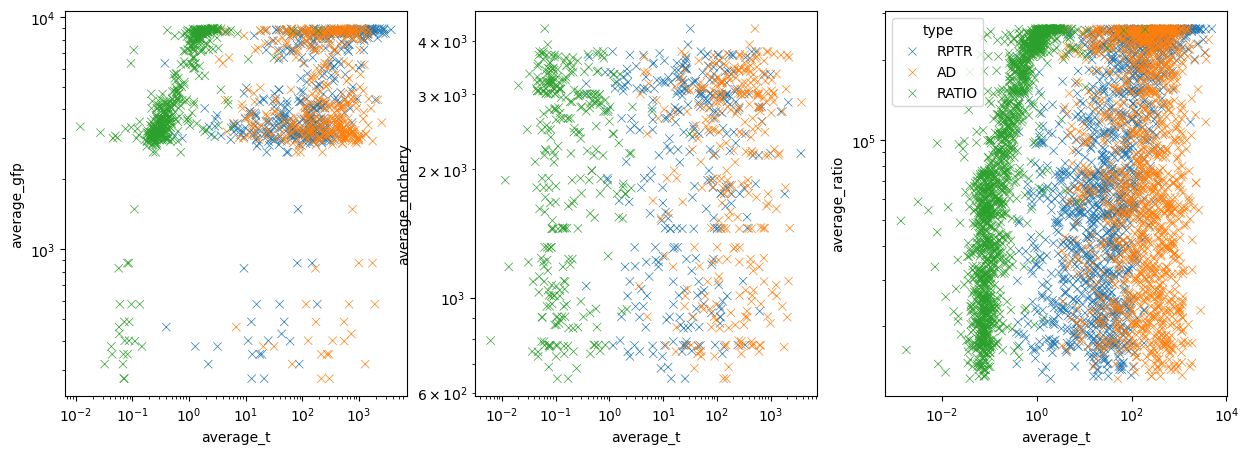

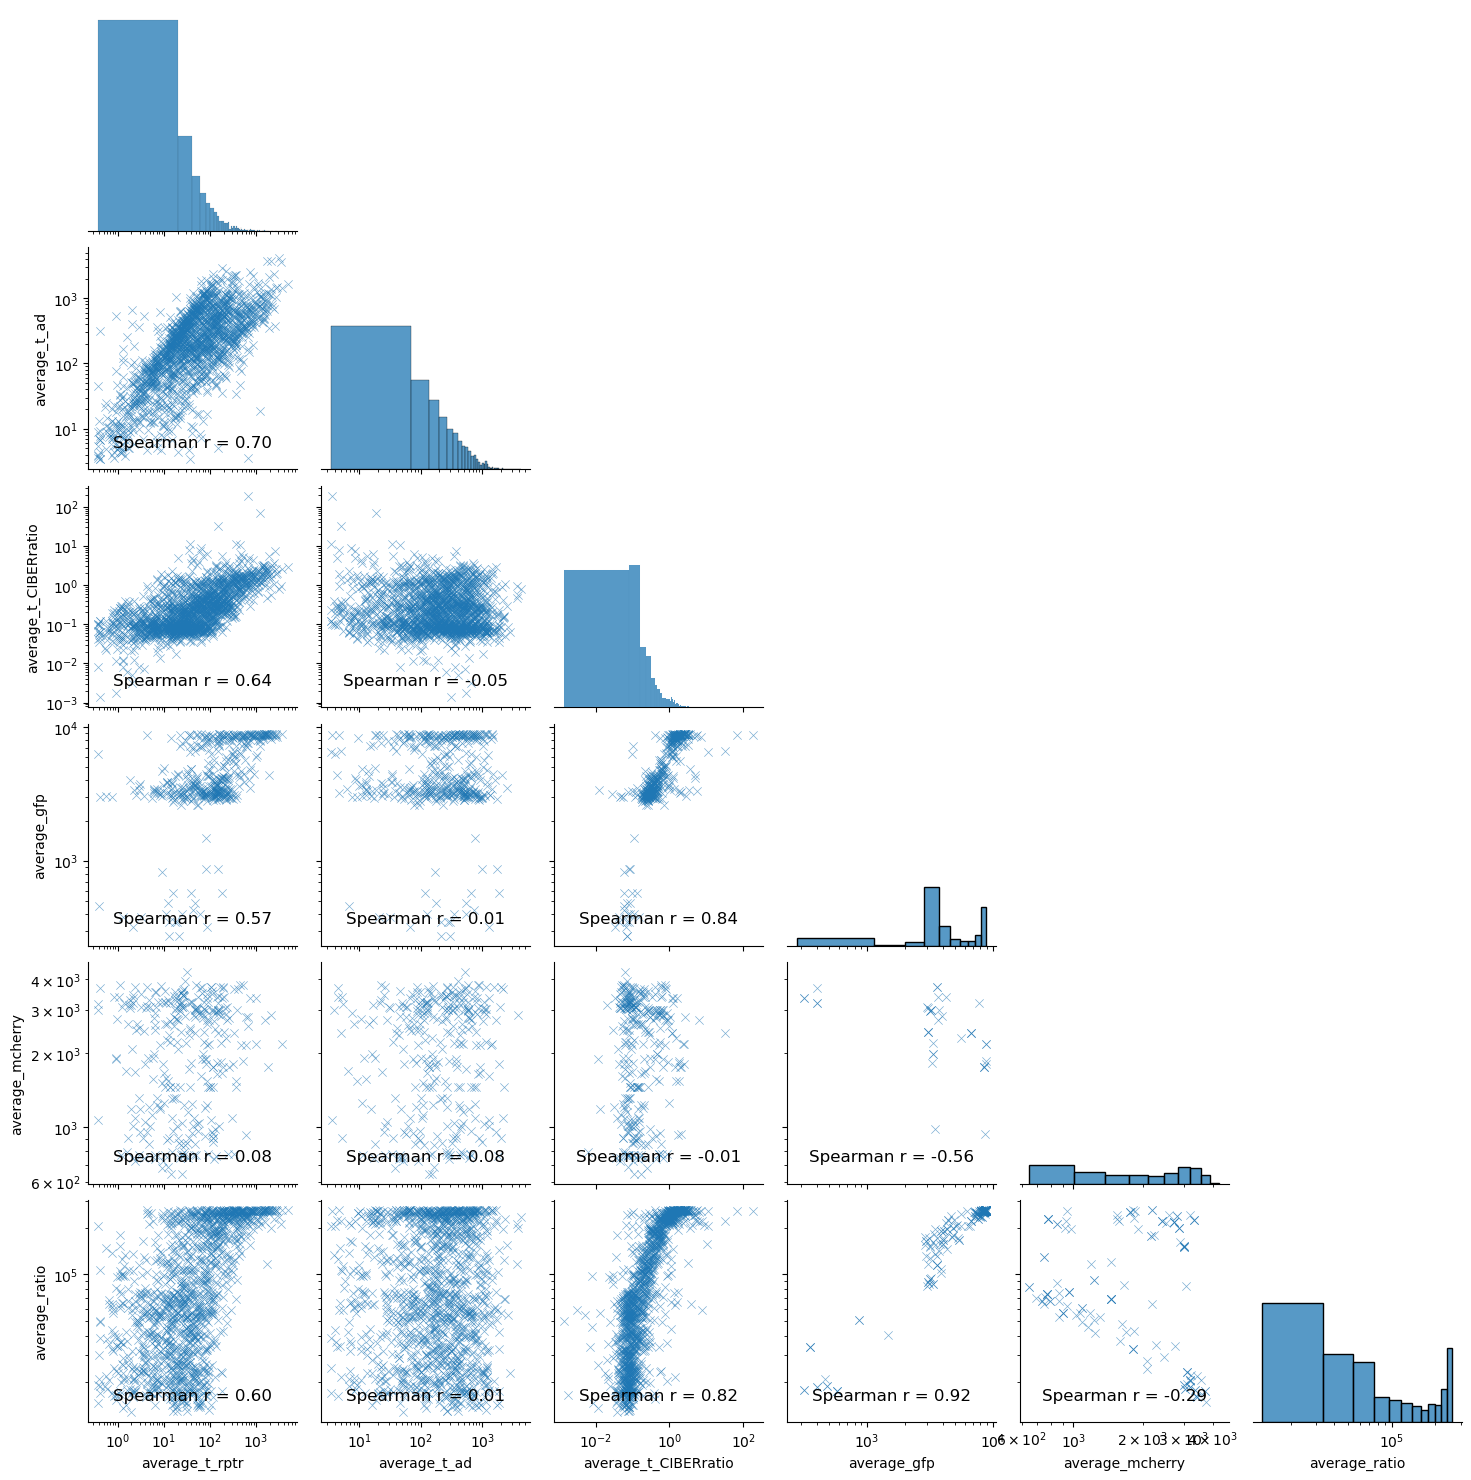

In [25]:
# ciber_combine('10')

In [26]:
time_list = [5, 10, 15, 30, 180, 240]
time_list = [str(x) for x in time_list]
time_list

['5', '10', '15', '30', '180', '240']

['merged_dfs/t5ratio_norm_nans.csv', 'merged_dfs/t5a_norm_nans.csv', 'merged_dfs/t5r_norm_nans.csv']
['merged_dfs/t10a_norm_nans.csv', 'merged_dfs/t10r_norm_nans.csv', 'merged_dfs/t10ratio_norm_nans.csv']
['merged_dfs/t15r_norm_nans.csv', 'merged_dfs/t15a_norm_nans.csv', 'merged_dfs/t15ratio_norm_nans.csv']
['merged_dfs/t30r_norm_nans.csv', 'merged_dfs/t30a_norm_nans.csv', 'merged_dfs/t30ratio_norm_nans.csv']
['merged_dfs/t180r_norm_nans.csv', 'merged_dfs/t180a_norm_nans.csv', 'merged_dfs/t180ratio_norm_nans.csv']
['merged_dfs/t240a_norm_nans.csv', 'merged_dfs/t240r_norm_nans.csv', 'merged_dfs/t240ratio_norm_nans.csv']


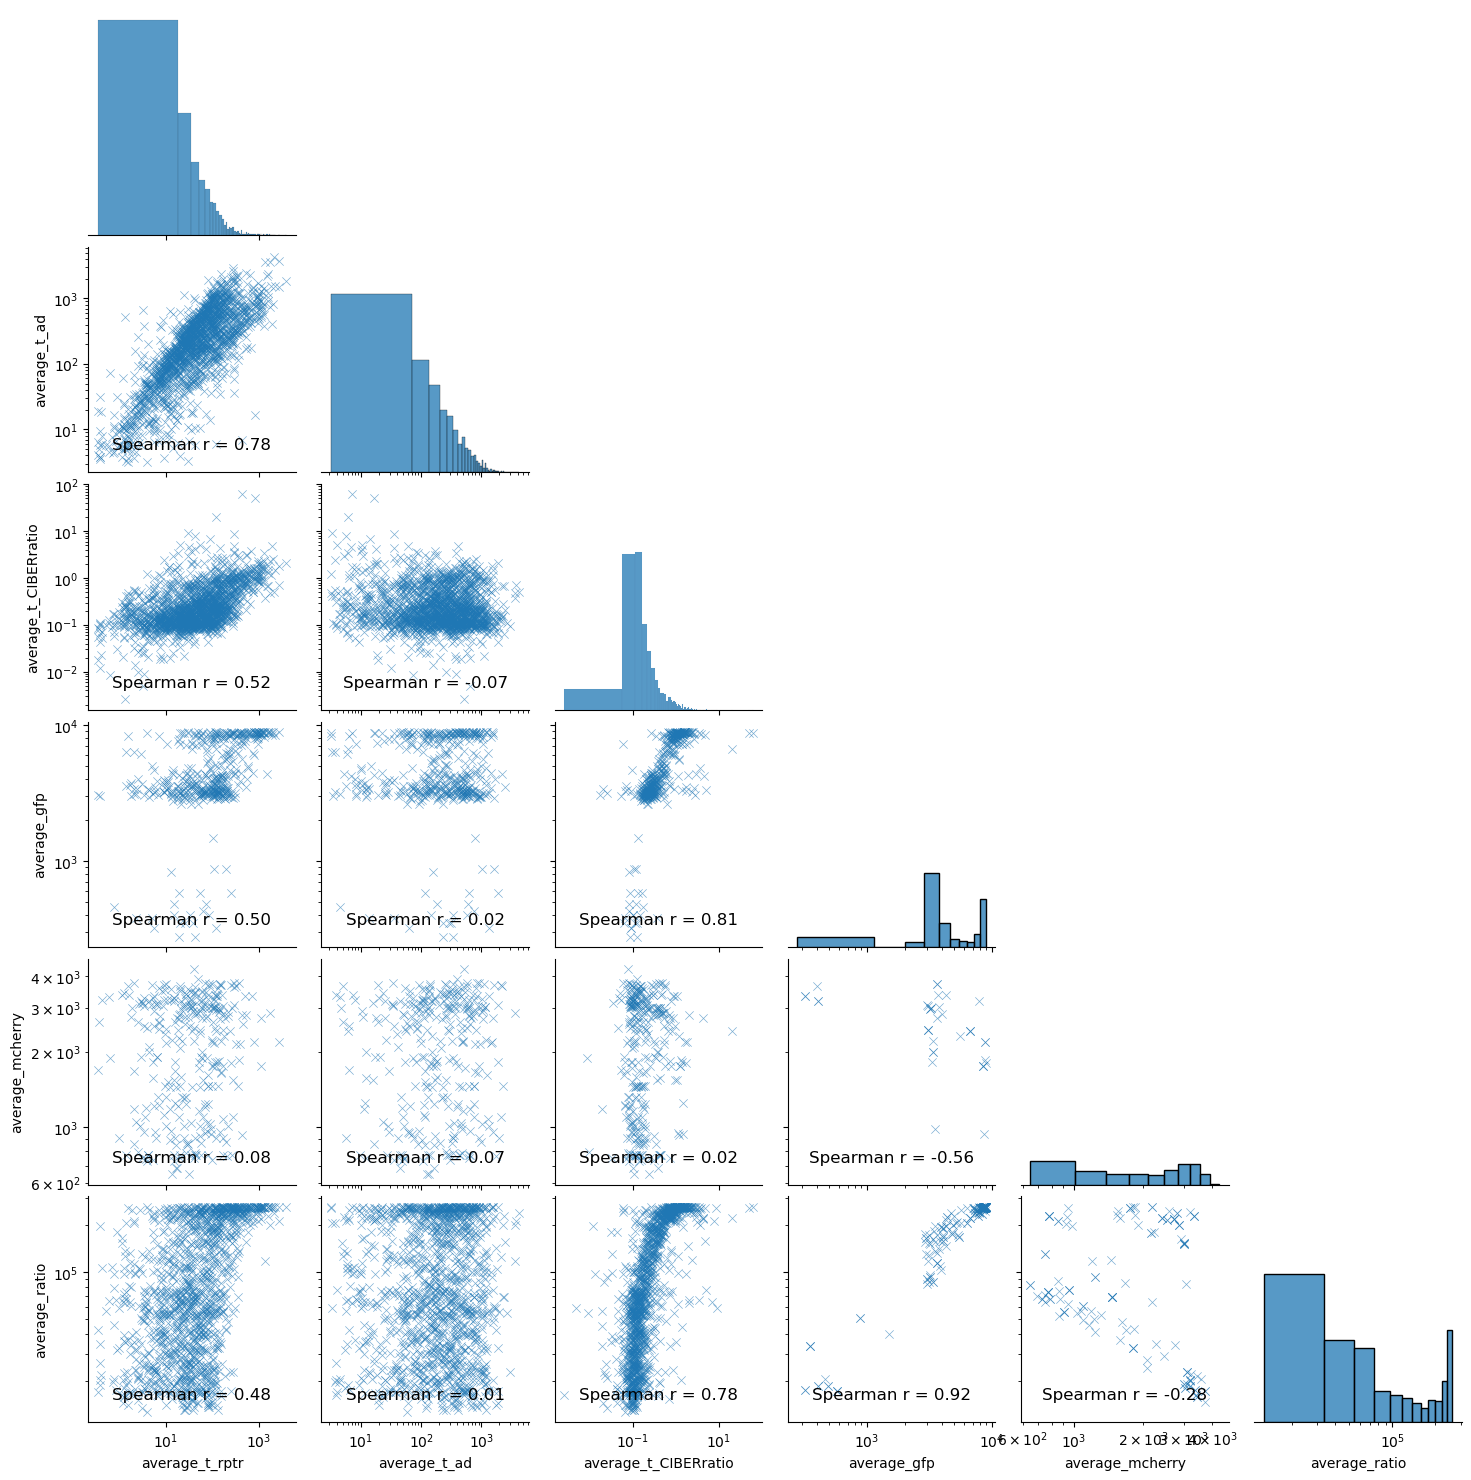

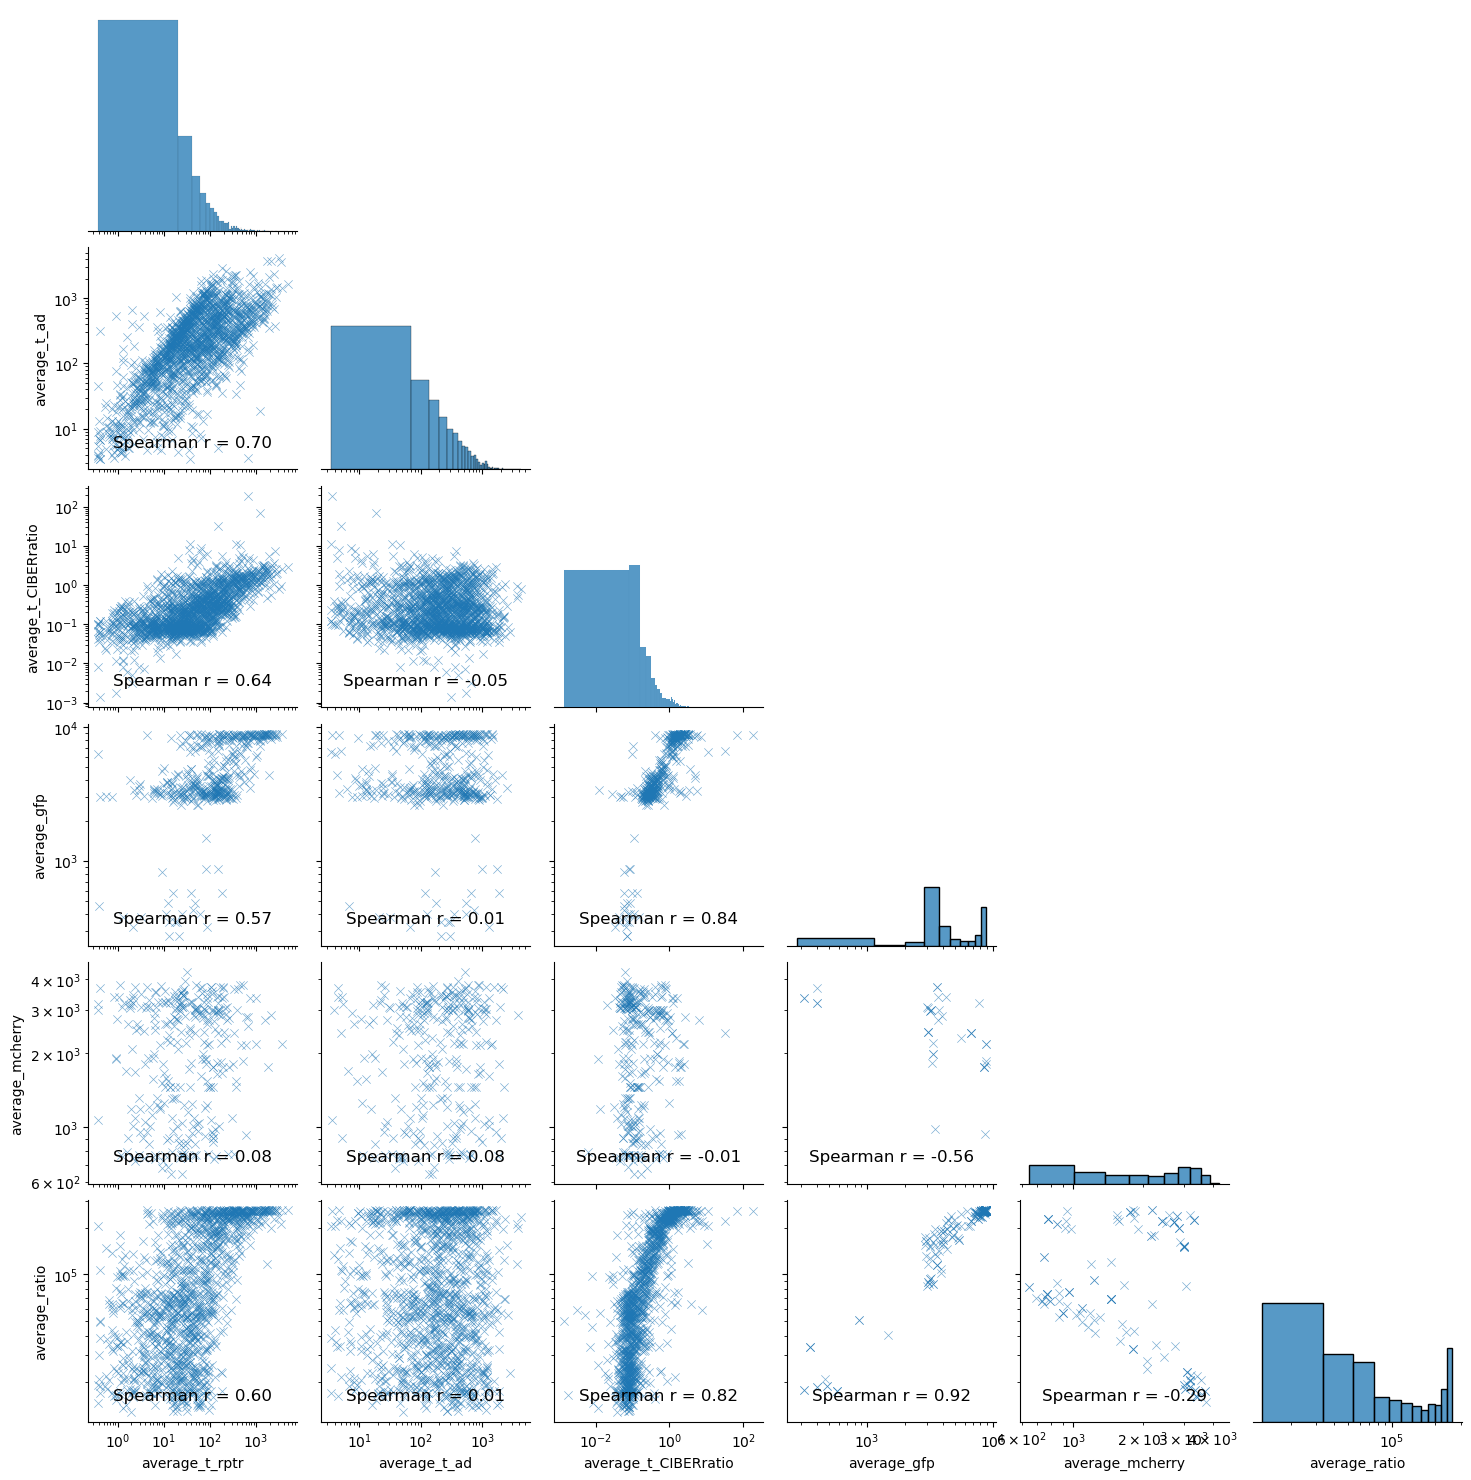

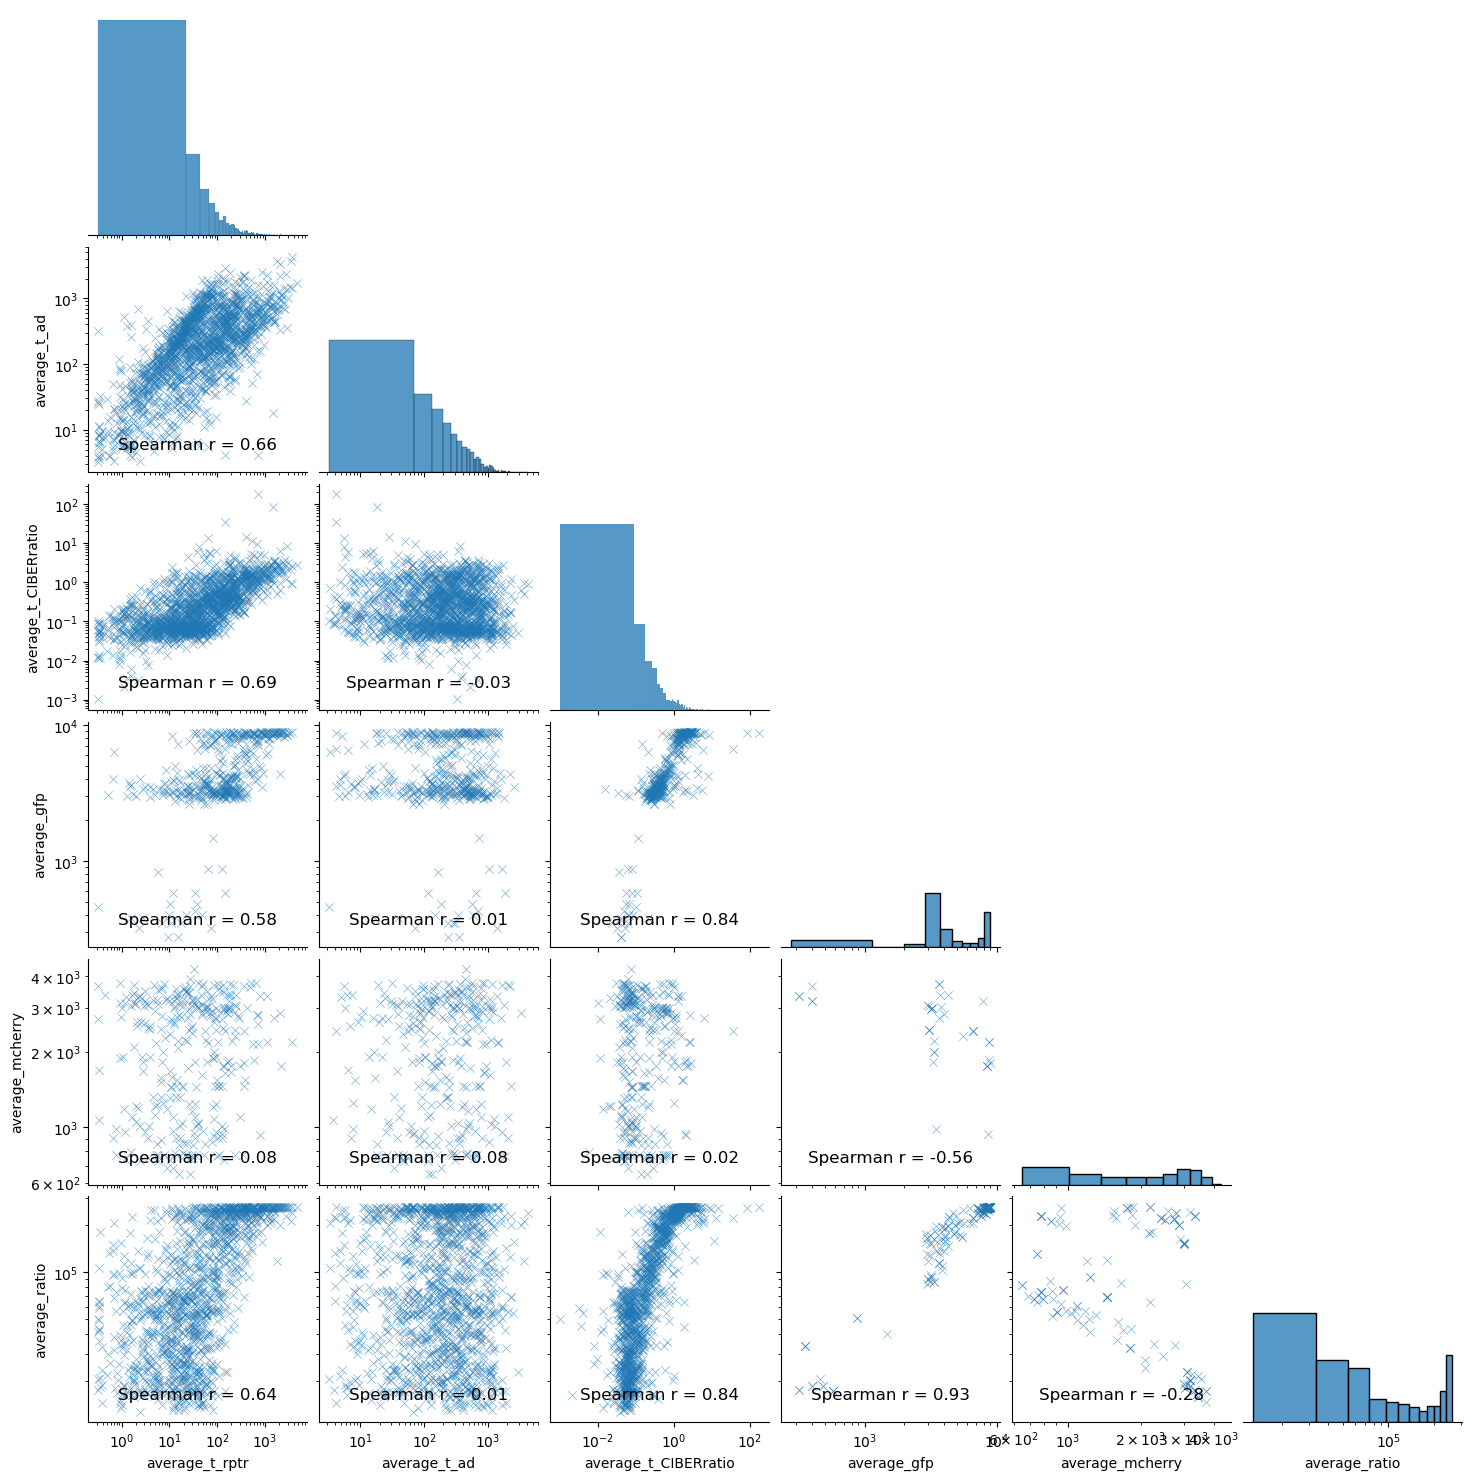

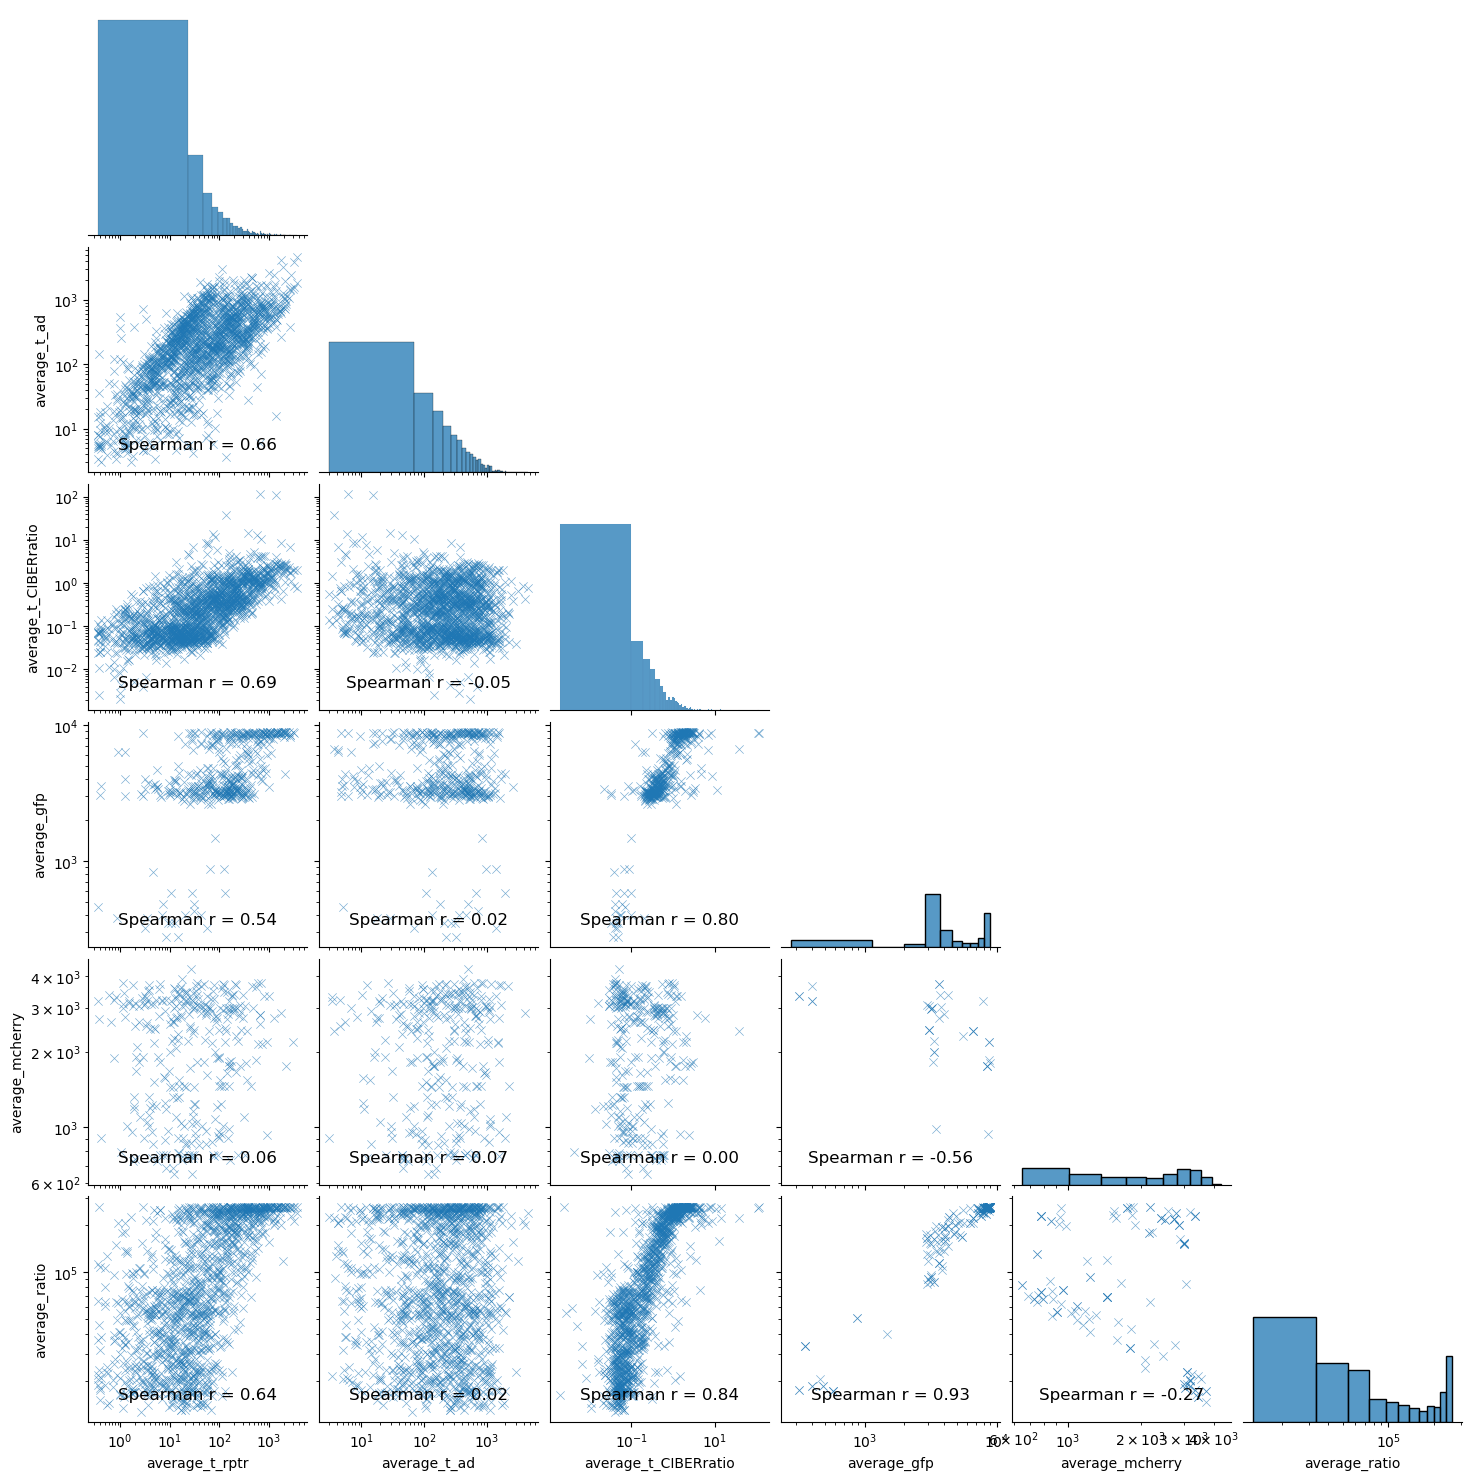

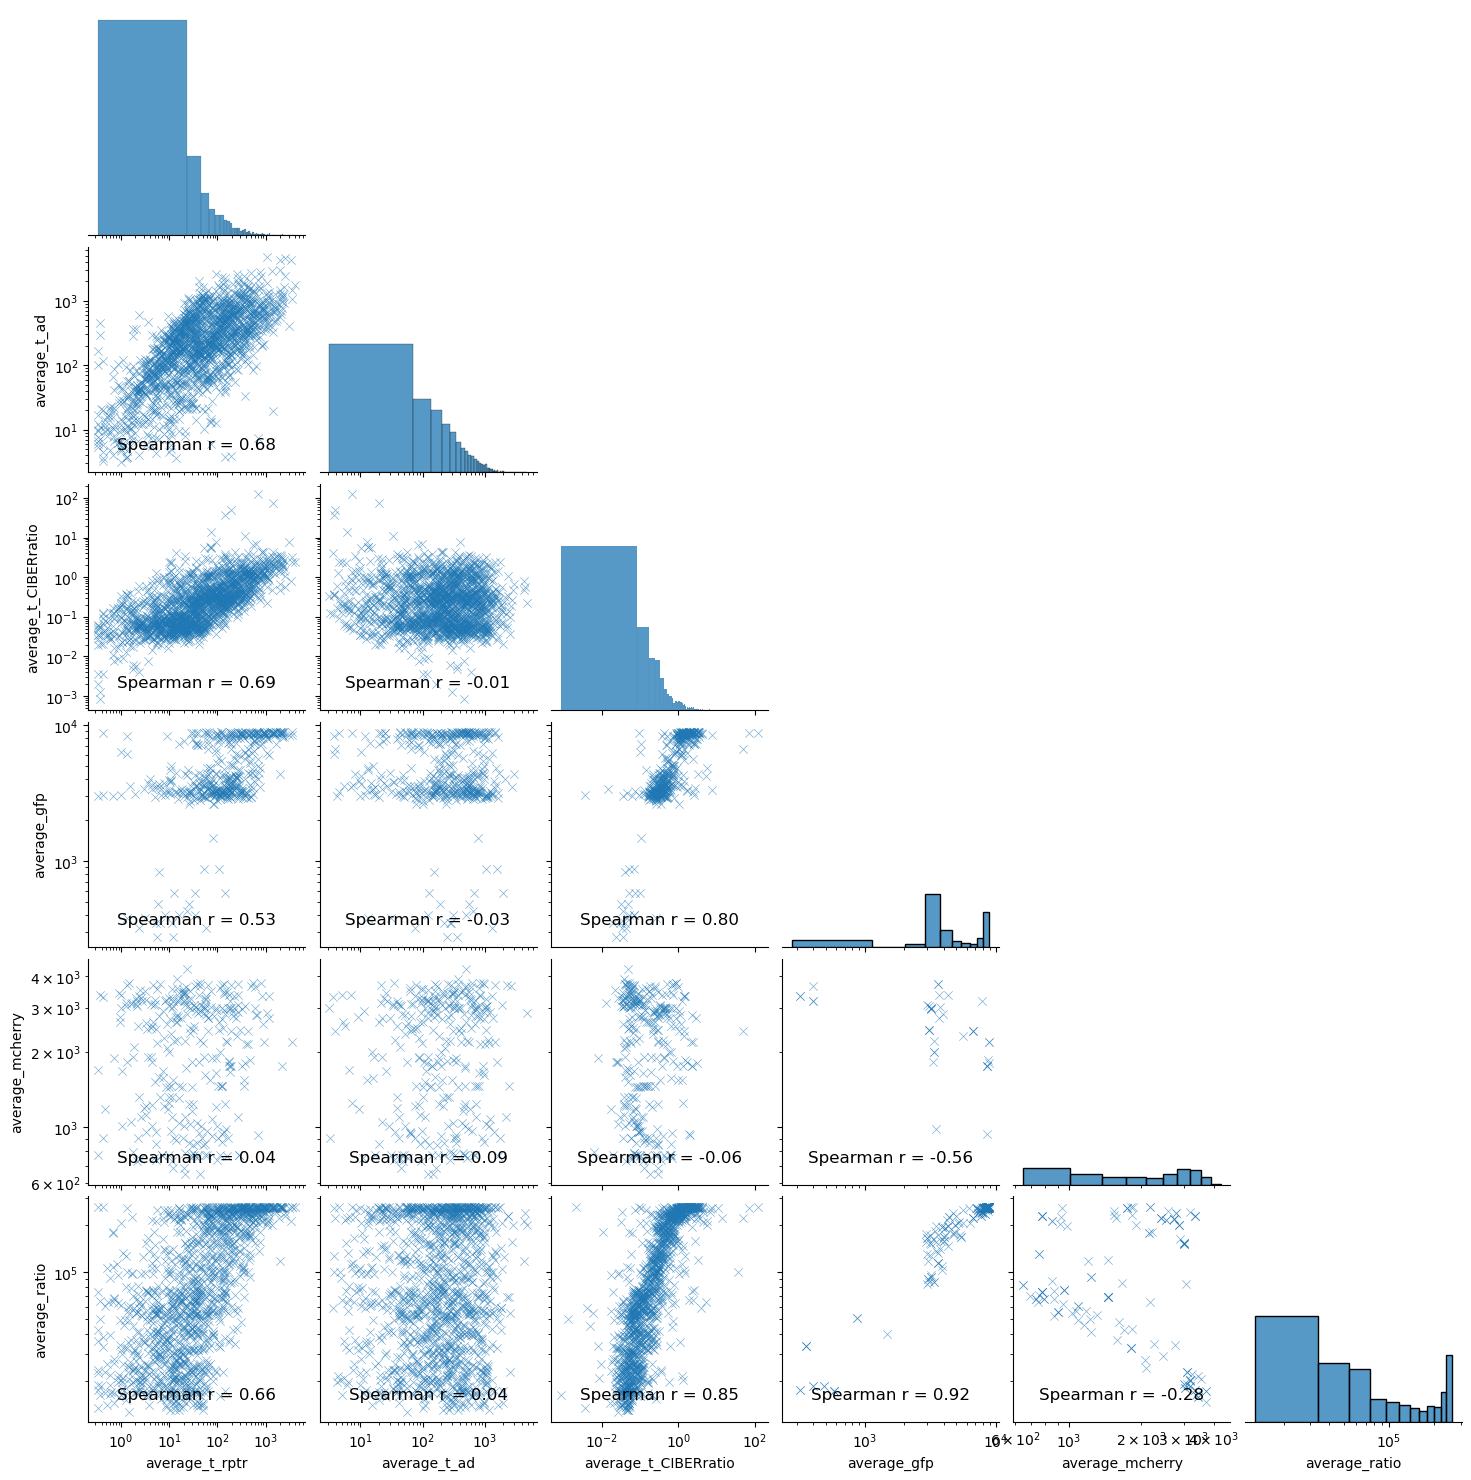

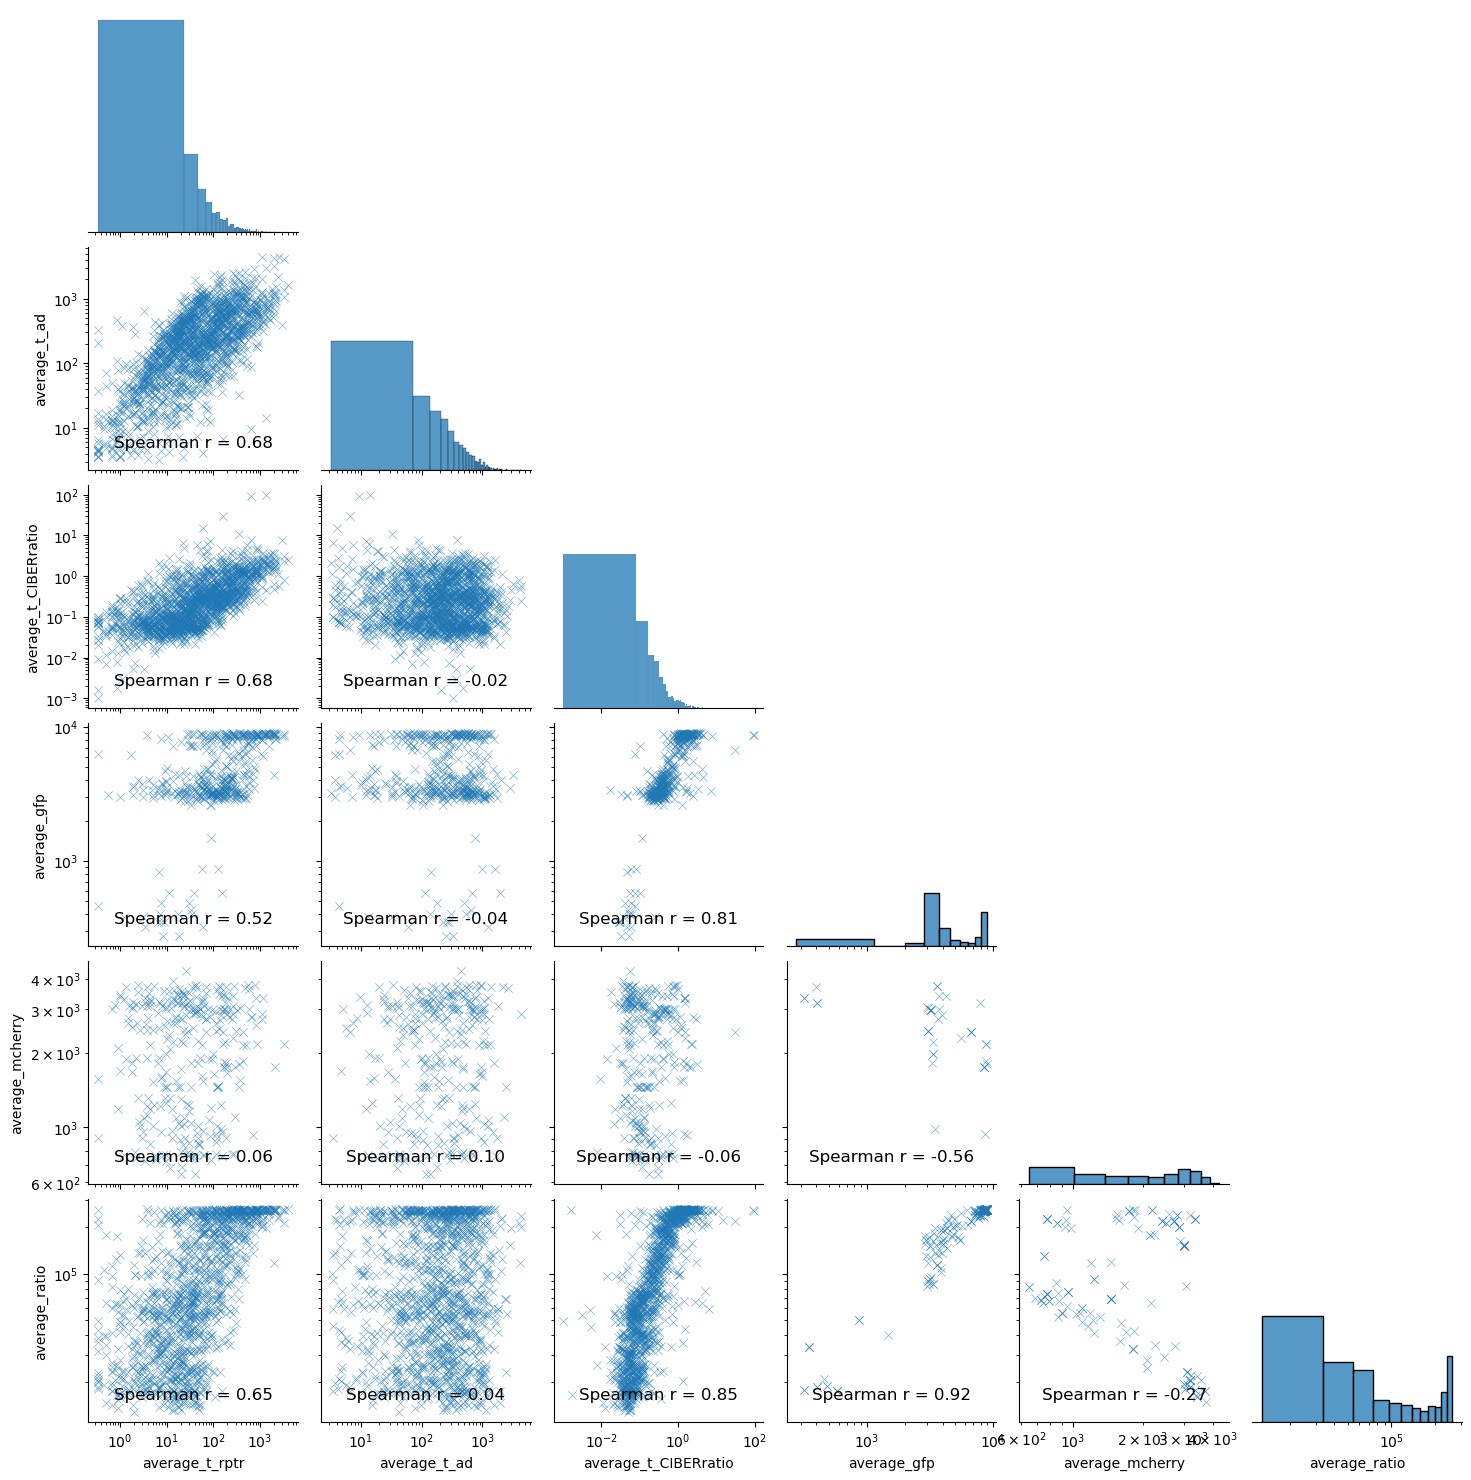

In [29]:
# for t in time_list:
#     ciber_combine(t)